### Import and Install Statements

In [1]:
# # StellarGraph and Word2Vec installs

# !conda install -y nltk
# !conda install -y -c stellargraph stellargraph==1.2.1
# !conda install -y -c conda-forge emoji
# !conda install -y scikit-learn

In [2]:
# !conda install -y tensorflow-gpu

In [3]:
# !conda install -y chardet

In [4]:
!nvidia-smi

Thu Apr 27 15:50:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   39C    P0    25W / 250W |      0MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   

In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-04-27 15:50:02.249713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-27 15:50:07.734476: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-27 15:50:07.735561: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-27 15:50:07.788764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-04-27 15:50:07.789109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
#Word2Vec Imports

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import emoji
import re

# General Imports
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# StellarGraph Imports

import stellargraph
from stellargraph import StellarGraph

# Training Imports
import json
import random
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics
import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras.backend as K

[nltk_data] Downloading package stopwords to
[nltk_data]     /storage/home/hcocice1/rgrover30/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /storage/home/hcocice1/rgrover30/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /storage/home/hcocice1/rgrover30/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2023-04-27 15:50:10.876774: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 15:50:10.876962: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-27 15:50:11.08

### Data Loading and Preprocessing

The textual columns were normalized by converting to lower, removing emoji, removing punctuation, and tokenization. The `collaborative` column was converted from Boolean to Categorical.

In [7]:
def preprocess_text(column):

    # Generate preprocessed words
    preprocessed_playlists = []
    for playlist in column:
        playlist_text = emoji.demojize(playlist)  # Convert emojis to textual representation
        playlist_text = re.sub(r'\W+', ' ', playlist_text) 
        playlist_text = playlist_text.replace('_',' ')
        tokens = word_tokenize(playlist_text)  # Tokenize text into words
        words = [word.lower() for word in tokens if word.isalnum()  ]  # Filtering punctuations and converting to lowercase
        l = " ".join(words)
        preprocessed_playlists.append(l)
    
    return preprocessed_playlists

In [8]:
# Loading the Data

with open('mpd.slice.0-999.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data['playlists'])

edges = []
all_tracks = dict()
count = 0

for index, playlist in df.iterrows():
  for track in playlist['tracks']:
    if track['track_uri'] not in all_tracks.keys():
      track['track_id'] = count
      count += 1
      all_tracks[track['track_uri']] = track
    edges.append([playlist['pid'], all_tracks[track['track_uri']]['track_id']])

all_tracks_df = pd.DataFrame.from_dict(all_tracks, orient='index').reset_index()
edges_df = pd.DataFrame(edges, columns=["source", "target"])

In [9]:
all_tracks_df['track_name'] = preprocess_text(all_tracks_df['track_name'])
all_tracks_df['artist_name'] = preprocess_text(all_tracks_df['artist_name'])
all_tracks_df['album_name'] = preprocess_text(all_tracks_df['album_name'])

df['name'] = preprocess_text(df['name'])

In [10]:
df.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,throwbacks,false,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,awesome playlist,false,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,false,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,false,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,false,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN


In [11]:
all_tracks_df.head()

,index,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,track_id
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0,missy elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,lose control feat ciara fat man scoop,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,the cookbook,0
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,1,britney spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,in the zone,1
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,2,beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,crazy in love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,dangerously in love alben für die ewigkeit,2
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,3,justin timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,rock your body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,justified,3
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,4,shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,it wasn t me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,hot shot,4


In [12]:
# Converting boolean to categorical 

df = df.drop(columns=['tracks','description'])
df['collaborative'] = df['collaborative'].astype('string')
df['collaborative'] = df['collaborative'].astype('category')
df['collaborative'] = df['collaborative'].cat.codes
df.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists
0,throwbacks,0,0,1493424000,52,47,1,6,11532414,37
1,awesome playlist,0,1,1506556800,39,23,1,5,11656470,21
2,korean,0,2,1505692800,64,51,1,18,14039958,31
3,mat,0,3,1501027200,126,107,1,4,28926058,86
4,90s,0,4,1401667200,17,16,2,7,4335282,16


### Label Encoding for Artist Name, Track Name and Album Name

In [13]:
encoder = LabelEncoder()


all_tracks_df['artist_encoded'] = encoder.fit_transform(all_tracks_df['artist_name'])
all_tracks_df['track_encoded'] = encoder.fit_transform(all_tracks_df['track_name'])
all_tracks_df['album_encoded'] = encoder.fit_transform(all_tracks_df['album_name'])
final_tracks_df = all_tracks_df[['track_id','pos','duration_ms','artist_encoded','track_encoded','album_encoded']]

### Label Encoding for Playlist Name

In [14]:
final_playlist_df = df
final_playlist_df['name_encoded']  = encoder.fit_transform(final_playlist_df['name'])
final_playlist_df = final_playlist_df.drop(columns = ['name'])

### Adding Prefix for Different Node Types

In [15]:
edges_df = edges_df.drop_duplicates()

def p(playlist):
    return "p_" + playlist.astype(str)

def t(track):
    return "t_" + track.astype(str)

playlists_final = final_playlist_df.copy(deep = True)
playlists_final['pid'] = p(final_playlist_df["pid"])
playlists_final.set_index("pid", inplace=True)

tracks_final = final_tracks_df.copy(deep = True)
tracks_final["track_id"] = t(final_tracks_df["track_id"])
tracks_final.set_index("track_id", inplace=True)

edges_final = pd.DataFrame()
edges_final["pid"] = p(edges_df["source"])
edges_final["track_id"] = t(edges_df["target"])

In [16]:
playlists_final.head()

,collaborative,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,name_encoded
pid,,,,,,,,,
p_0,0,1493424000,52,47,1,6,11532414,37,674
p_1,0,1506556800,39,23,1,5,11656470,21,60
p_2,0,1505692800,64,51,1,18,14039958,31,354
p_3,0,1501027200,126,107,1,4,28926058,86,389
p_4,0,1401667200,17,16,2,7,4335282,16,26


In [17]:
tracks_final.head()

,pos,duration_ms,artist_encoded,track_encoded,album_encoded
track_id,,,,,
t_0,0,226863,5819,15095,14036
t_1,1,198800,1173,26225,7085
t_2,2,235933,850,5233,3436
t_3,3,267266,4435,20584,7523
t_4,4,227600,7412,13019,6498


In [18]:
edges_final.head()

,pid,track_id
0,p_0,t_0
1,p_0,t_1
2,p_0,t_2
3,p_0,t_3
4,p_0,t_4


### Graph Creation Using StellarGraph

In [19]:
graph = StellarGraph(
    {"playlists": playlists_final, "tracks": tracks_final},
    {"link": edges_final[["pid", "track_id"]]},
    source_column="pid",
    target_column="track_id",
)

In [20]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 35443, Edges: 66721

 Node types:
  tracks: [34443]
    Features: float32 vector, length 5
    Edge types: tracks-link->playlists
  playlists: [1000]
    Features: float32 vector, length 9
    Edge types: playlists-link->tracks

 Edge types:
    playlists-link->tracks: [66721]
        Weights: all 1 (default)
        Features: none


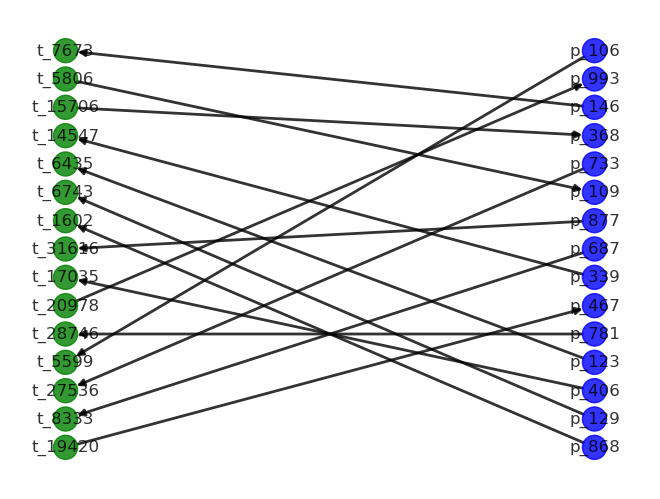

In [51]:
import networkx as nx

G = graph.to_networkx()
subgraph_edges = random.sample(list(G.edges()), 15)
first_elements = [e[0] for e in subgraph_edges]
second_elements = [e[1] for e in subgraph_edges]
subgraph_nodes = set(n for e in subgraph_edges for n in e)
subgraph = G.subgraph(subgraph_nodes)

node_colors = []
for node in subgraph.nodes():
    if node in first_elements:
        node_colors.append("green")
    elif node in second_elements:
        node_colors.append("blue")
    else:
        node_colors.append("red")
pos = nx.bipartite_layout(subgraph, nodes=first_elements)

nx.draw(subgraph, pos=pos, with_labels=True, node_color=node_colors, width=2, alpha=0.8, arrows=True)

### Negative Sampling of Edges

In [24]:
batch_size = 64
epochs = 30
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [22]:
random.seed(42)
num_neg_samples = int(len(edges_final))
neg_samples = []

while len(neg_samples) < num_neg_samples:
    random_track = random.sample(tracks_final.reset_index()['track_id'].to_list(),1)
    random_playlist = random.sample(playlists_final.reset_index()['pid'].to_list(),1)
    if ([random_playlist,random_track] not in edges_final.to_numpy()):
        neg_samples.append([random_playlist,random_track])
        
neg_samples = np.array(neg_samples).reshape((len(neg_samples),2))

In [25]:
neg_df = pd.DataFrame(neg_samples,columns=['pid','track_id'])

neg_edges_train, neg_edges_test = model_selection.train_test_split(
    neg_df, train_size=train_size, test_size=test_size
)

neg_edgelist_train = list(neg_edges_train[["pid", "track_id"]].itertuples(index=False))
neg_edgelist_test = list(neg_edges_test[["pid", "track_id"]].itertuples(index=False))

neg_labels_train = np.zeros(len(neg_edgelist_train))
neg_labels_test = np.zeros(len(neg_edgelist_test))

### Train-Test Split

In [26]:
edges_train, edges_test = model_selection.train_test_split(
    edges_final, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["pid", "track_id"]].itertuples(index=False))
edgelist_test = list(edges_test[["pid", "track_id"]].itertuples(index=False))

labels_train = np.ones(len(edgelist_train))
labels_test = np.ones(len(edgelist_test))

In [27]:
len(neg_edgelist_train)

46704

In [28]:
len(edgelist_train)

46704

In [29]:
x_train = np.vstack((edgelist_train,neg_edgelist_train))
x_test = np.vstack((edgelist_test,neg_edgelist_test))
y_train = np.hstack((labels_train,neg_labels_train))
y_test = np.hstack((labels_test,neg_labels_test))

### Specifying Hyperparameters

In [30]:
num_samples = [8,4]

In [31]:
generator = HinSAGELinkGenerator(
    graph, batch_size, num_samples, head_node_types=["playlists", "tracks"]
)
train_gen = generator.flow(x_train, y_train, shuffle=True)
test_gen = generator.flow(x_test, y_test)

In [32]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('playlists', [2]),
 ('tracks', [3]),
 ('tracks', [4]),
 ('playlists', [5]),
 ('playlists', []),
 ('tracks', [])]

In [33]:
hinsage_layer_sizes = [32, 16]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)

In [34]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [35]:
# Final estimator layer
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [36]:
def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=5e-4),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 5)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 9)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 5)]      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1, 9)]       0                                            
______________________________________________________________________________________________

In [38]:
num_workers = 4

test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=True, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2023-04-27 15:54:17.552802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-27 15:54:17.553372: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2500000000 Hz


2023-04-27 15:54:18.241441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


626/626 [==============================] - 6s 8ms/step - loss: 0.4954 - root_mean_square_error: 0.6784 - mean_absolute_error: 0.6784
Untrained model's Test Evaluation:
	loss: 0.3165
	root_mean_square_error: 0.4990
	mean_absolute_error: 0.4991


### Model Training

In [39]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=True,
    workers=num_workers,
)

Epoch 1/30
1460/1460 [==============================] - 21s 13ms/step - loss: 0.2392 - root_mean_square_error: 0.4889 - mean_absolute_error: 0.4831 - val_loss: 0.2172 - val_root_mean_square_error: 0.4652 - val_mean_absolute_error: 0.4379
Epoch 2/30
1460/1460 [==============================] - 19s 13ms/step - loss: 0.2169 - root_mean_square_error: 0.4652 - mean_absolute_error: 0.4352 - val_loss: 0.2132 - val_root_mean_square_error: 0.4609 - val_mean_absolute_error: 0.4271
Epoch 3/30
1460/1460 [==============================] - 18s 13ms/step - loss: 0.2142 - root_mean_square_error: 0.4623 - mean_absolute_error: 0.4289 - val_loss: 0.2119 - val_root_mean_square_error: 0.4597 - val_mean_absolute_error: 0.4261
Epoch 4/30
1460/1460 [==============================] - 19s 13ms/step - loss: 0.2135 - root_mean_square_error: 0.4614 - mean_absolute_error: 0.4266 - val_loss: 0.2128 - val_root_mean_square_error: 0.4602 - val_mean_absolute_error: 0.4219
Epoch 5/30
1460/1460 [==========================

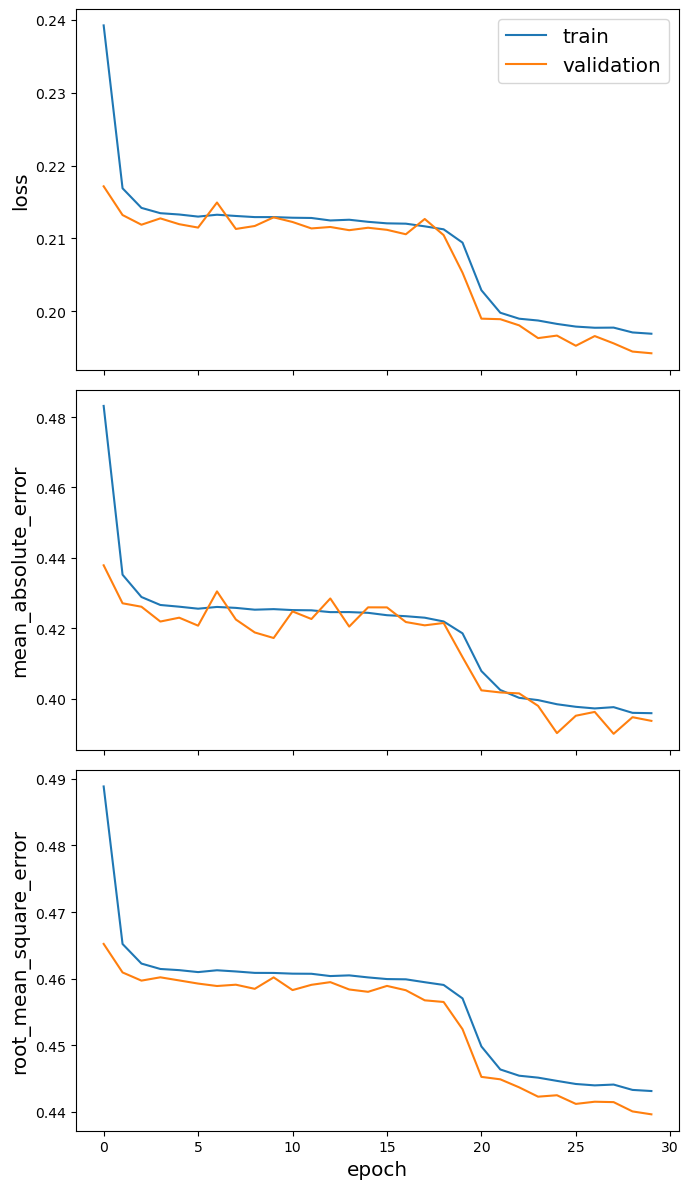

In [40]:
sg.utils.plot_history(history)

In [41]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

626/626 [==============================] - 9s 14ms/step - loss: 0.1948 - root_mean_square_error: 0.4403 - mean_absolute_error: 0.3945
Test Evaluation:
	loss: 0.1948
	root_mean_square_error: 0.4403
	mean_absolute_error: 0.3945


### Use 0.7 as cut-off for high probability recommendations

In [42]:
y_true = y_test
y_pred = model.predict(test_gen)
y_pred[y_pred >= 0.7] = 1
y_pred[y_pred < 0.7] = 0

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)


Model Test set metrics:
	root_mean_square_error =  0.6370283083930885
	mean_absolute_error =  0.40580506569415997


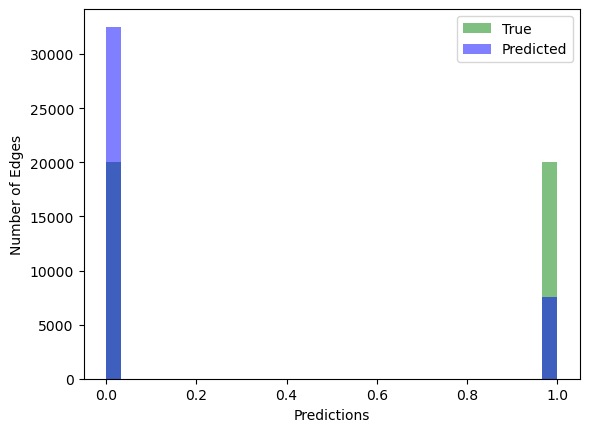

In [43]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("Predictions")
plt.ylabel("Number of Edges")
plt.legend(("True", "Predicted"))
plt.show()

### Evaluation Metrics 

#### R-Precision = 0.2756

In [44]:
y_true_idx = np.where(y_true == 1)[0]
y_true_idx

array([    0,     1,     2, ..., 20014, 20015, 20016])

In [45]:
y_pred_idx = np.where(y_pred >= 0.7)[0]
y_pred_idx

array([    0,     3,     5, ..., 40006, 40015, 40027])

In [46]:
target_set = set(y_true_idx)
target_count = len(y_true_idx)
float(len(set(y_pred_idx).intersection(y_true_idx))) / target_count

0.28171054603586954

#### DCG = 0.32515

In [47]:
from collections import OrderedDict

In [48]:
def dcg(relevant_elements, retrieved_elements):
    retrieved_elements = list(OrderedDict.fromkeys(retrieved_elements))
    relevant_elements = list(OrderedDict.fromkeys(relevant_elements))
    if len(retrieved_elements) == 0 or len(relevant_elements) == 0:
        return 0.0
    score = [float(el in relevant_elements) for el in retrieved_elements]
    return np.sum(score / np.log2(1 + np.arange(1, len(score) + 1)))

In [49]:
idcg = dcg(y_true_idx, y_true_idx)
true_dcg = dcg(y_true_idx, y_pred_idx)
ndcg = true_dcg/idcg

In [50]:
ndcg

0.33127583102075003